In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.gnn as gnn
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
num_nodes, node_dim = 10, 5

dataset = random_graph_dataset.RandomGraphDataset(
    node_dim, num_items=6400,
    graph_type="degree", num_nodes=num_nodes, noise_level=0
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0  # TODO: allow multi-processing
)

### Create the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliOneSkipDiffuser(10, 100, (1,))  # Make input shape just 1

t_limit = 1000

model = gnn.GraphLinkGAT(
    node_dim, t_limit,
    num_gnn_layers=5
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models/misc"

import model.train_model as train_model  # Import this AFTER setting environment

### Show the forward-diffusion process

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


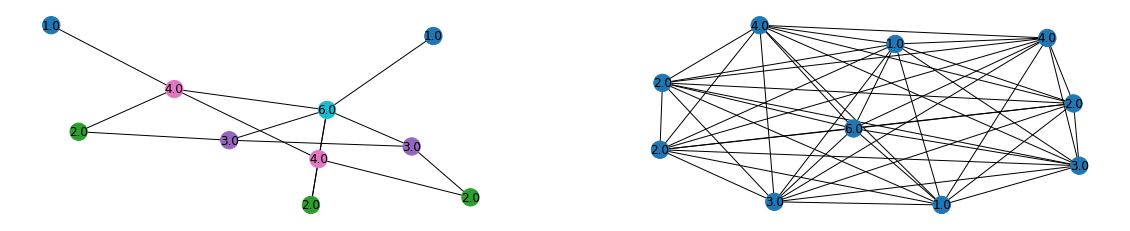

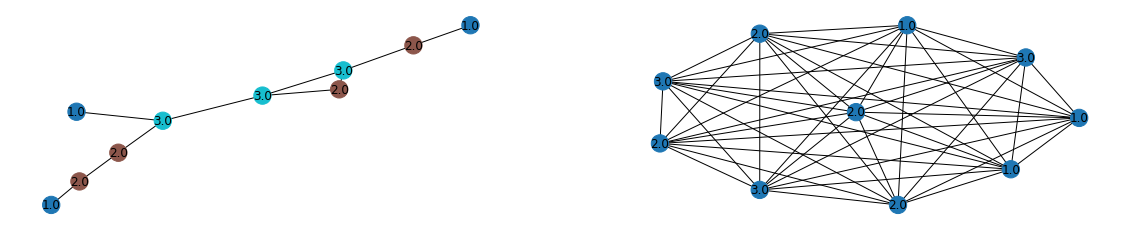

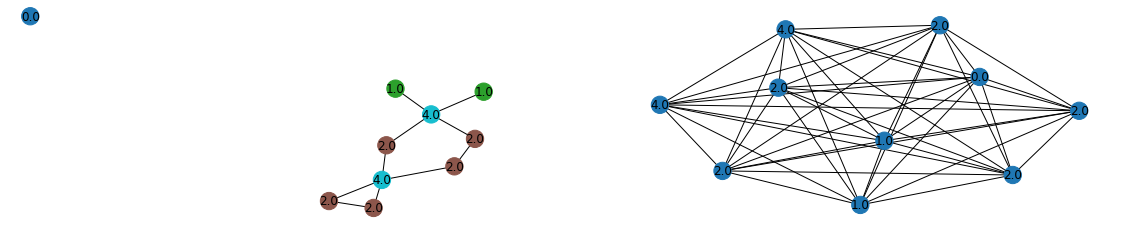

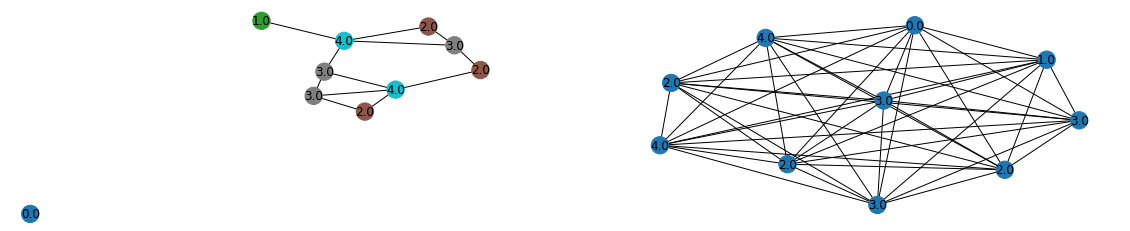

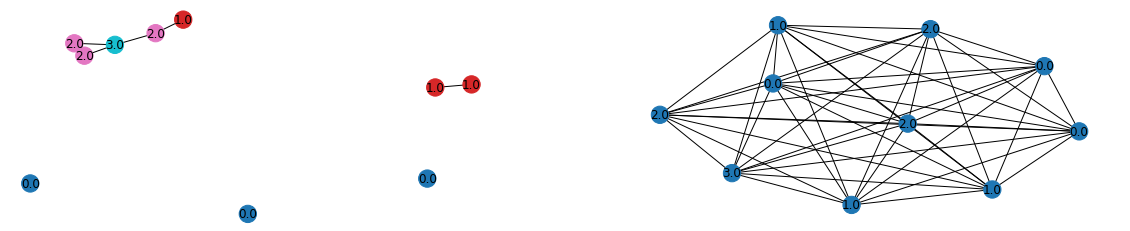

In [5]:
# Check the NetworkX graphs in a batch directly from the data loader, and
# after adding noise for a long time
data = next(iter(data_loader))

graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)

e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = diffuser.forward(e0[:, None], t_e, return_posterior=False)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)

graphs_t = graph_conversions.split_pyg_data_to_nx_graphs(data)

for i in np.random.choice(len(graphs_0), replace=False, size=min(5, len(graphs_0))):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    degrees = dict(graphs_0[i].degree())
    node_degrees = [degrees[n] for n in range(len(graphs_0[i]))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(graphs_0[i]), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(graphs_0[i], ax=ax[0], node_color=node_degrees, labels=labels, cmap="tab10")
    degrees = dict(graphs_t[i].degree())
    node_degrees = [degrees[n] for n in range(len(graphs_0[i]))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(graphs_t[i]), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(graphs_t[i], ax=ax[1], node_color=node_degrees, labels=labels, cmap="tab10")
    plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

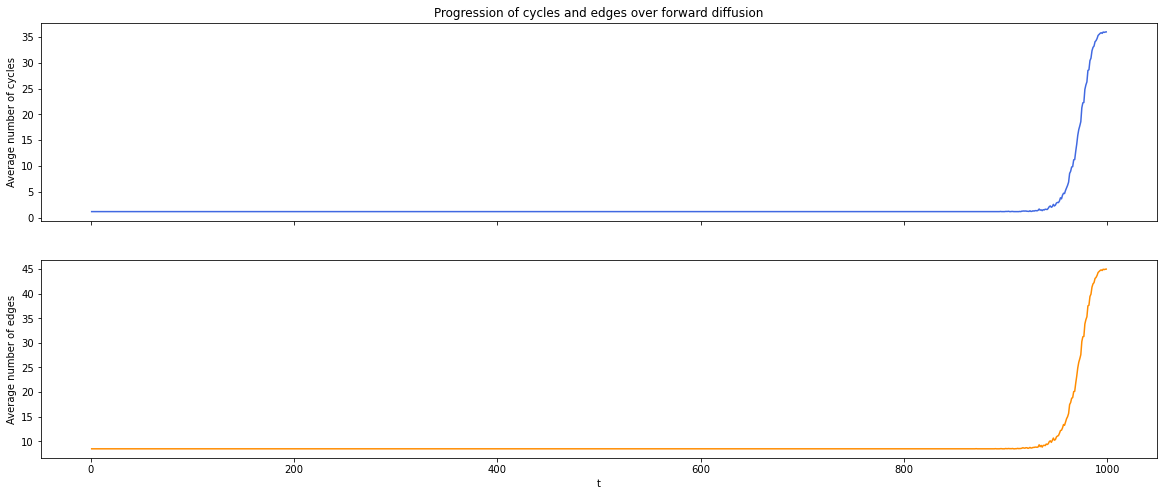

In [6]:
# Check progression of the number of cycles and edges
t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = diffuser.forward(e0[None], t_tens, return_posterior=False)[0]  # Do the noising on 1 x E tensors
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

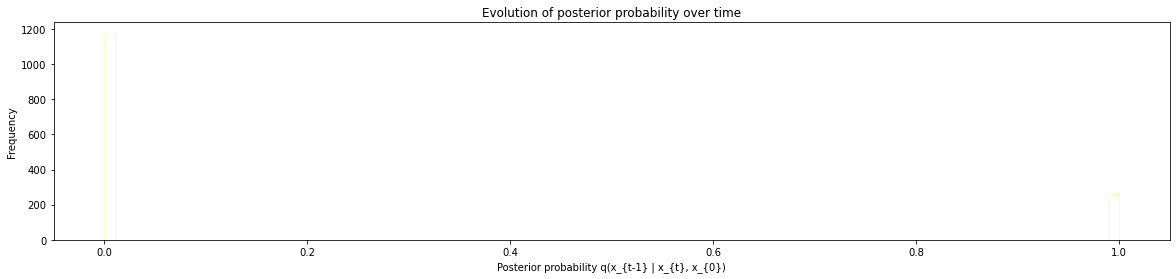

In [7]:
### Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et, p = diffuser.forward(e0[None], t_tens)  # Do the noising on 1 x E tensors
    et, p = et[0], p[0]
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 4))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

### Train the model

In [8]:
train_model.train_ex.run(
    "train_graph_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "num_epochs": 50,
        "learning_rate": 0.0001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_graph_model'
INFO - train - Started run with ID "116"
Loss: 0.3403: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.82it/s]


Epoch 1 average Loss: 0.3779


Loss: 0.2827: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.86it/s]


Epoch 2 average Loss: 0.3079


Loss: 0.2309: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.87it/s]


Epoch 3 average Loss: 0.2733


Loss: 0.2011: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.87it/s]


Epoch 4 average Loss: 0.2390


Loss: 0.2138: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.85it/s]


Epoch 5 average Loss: 0.2187


Loss: 0.1850: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.85it/s]


Epoch 6 average Loss: 0.2046


Loss: 0.1553: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s]


Epoch 7 average Loss: 0.1852


Loss: 0.1666: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s]


Epoch 8 average Loss: 0.1740


Loss: 0.1629: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s]


Epoch 9 average Loss: 0.1578


Loss: 0.1975: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.85it/s]


Epoch 10 average Loss: 0.1428


Loss: 0.1322: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s]


Epoch 11 average Loss: 0.1278


Loss: 0.1292: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.86it/s]


Epoch 12 average Loss: 0.1170


Loss: 0.0710: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s]


Epoch 13 average Loss: 0.1120


Loss: 0.0937: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.85it/s]


Epoch 14 average Loss: 0.1005


Loss: 0.0862: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.86it/s]


Epoch 15 average Loss: 0.0943


Loss: 0.0843: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.86it/s]


Epoch 16 average Loss: 0.0888


Loss: 0.0872: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.36it/s]


Epoch 17 average Loss: 0.0826


Loss: 0.0666: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.36it/s]


Epoch 18 average Loss: 0.0769


Loss: 0.0817: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.42it/s]


Epoch 19 average Loss: 0.0752


Loss: 0.0474: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.38it/s]


Epoch 20 average Loss: 0.0718


Loss: 0.0281: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.36it/s]


Epoch 21 average Loss: 0.0671


Loss: 0.0600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.72it/s]


Epoch 22 average Loss: 0.0633


Loss: 0.0380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.92it/s]


Epoch 23 average Loss: 0.0613


Loss: 0.0570: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 24 average Loss: 0.0558


Loss: 0.0667: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.96it/s]


Epoch 25 average Loss: 0.0544


Loss: 0.0448: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 26 average Loss: 0.0540


Loss: 0.0567: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 27 average Loss: 0.0504


Loss: 0.0656: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 28 average Loss: 0.0519


Loss: 0.0277: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.90it/s]


Epoch 29 average Loss: 0.0501


Loss: 0.0707: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.96it/s]


Epoch 30 average Loss: 0.0468


Loss: 0.0298: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 31 average Loss: 0.0454


Loss: 0.0525: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 32 average Loss: 0.0456


Loss: 0.0297: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 33 average Loss: 0.0406


Loss: 0.0172: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 34 average Loss: 0.0410


Loss: 0.0576: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.90it/s]


Epoch 35 average Loss: 0.0401


Loss: 0.0280: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 36 average Loss: 0.0403


Loss: 0.0168: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 37 average Loss: 0.0395


Loss: 0.0334: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 38 average Loss: 0.0392


Loss: 0.0484: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 39 average Loss: 0.0352


Loss: 0.0259: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 40 average Loss: 0.0371


Loss: 0.0533: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.89it/s]


Epoch 41 average Loss: 0.0373


Loss: 0.0234: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 42 average Loss: 0.0337


Loss: 0.0246: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 43 average Loss: 0.0342


Loss: 0.0456: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 44 average Loss: 0.0341


Loss: 0.0508: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.93it/s]


Epoch 45 average Loss: 0.0344


Loss: 0.0247: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.93it/s]


Epoch 46 average Loss: 0.0312


Loss: 0.0230: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.90it/s]


Epoch 47 average Loss: 0.0315


Loss: 0.0139: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 48 average Loss: 0.0302


Loss: 0.0446: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 49 average Loss: 0.0337


Loss: 0.0117: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]
INFO - train - Completed after 0:28:31


Epoch 50 average Loss: 0.0320


### Show generated graphs

In [9]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

# Sample from the prior
data = next(iter(data_loader))
edges = graph_conversions.pyg_data_to_edge_vector(data)
sampled_edges = diffuser.sample_prior(
    edges.shape[0], # Samples will be E x 1
    torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
)[:, 0]  # Shape: E
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)

samples, times = generate.generate_graph_samples(
    model, diffuser, data, t_limit=t_limit, return_all_times=True
)
times = times.cpu().numpy()
# Split samples into individual graphs
graph_samples = [
    graph_conversions.split_pyg_data_to_nx_graphs(sample)
    for sample in samples
]

Sampling some reverse trajectories


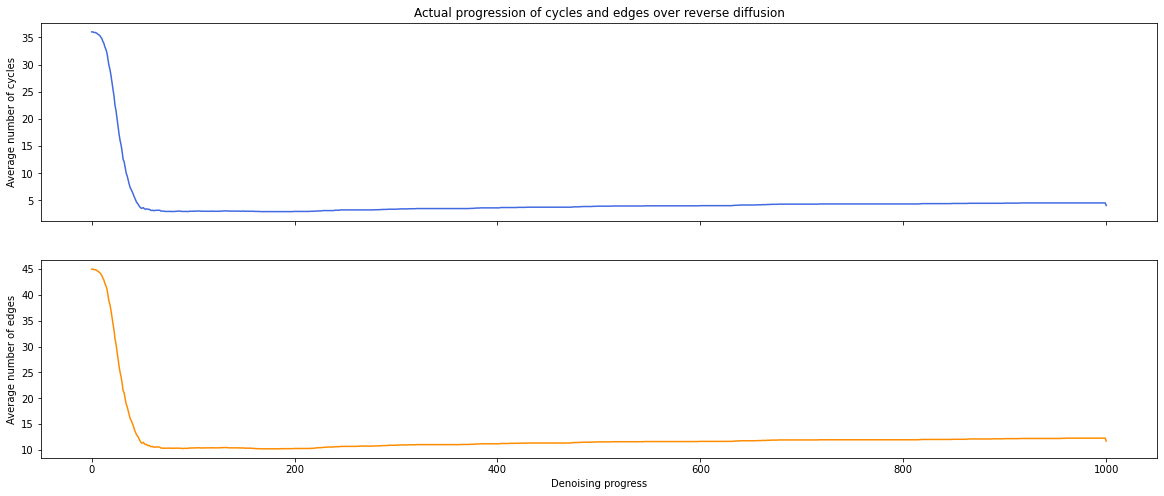

In [10]:
# Check progression of the number of cycles and edges
num_cycles = np.empty((len(graph_samples), len(graph_samples[0])))
num_edges = np.empty((len(graph_samples), len(graph_samples[0])))
for i in range(len(graph_samples)):
    for j, g in enumerate(graph_samples[i]):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(np.arange(len(graph_samples)), np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(np.arange(len(graph_samples)), np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("Denoising progress")

ax[0].set_title("Actual progression of cycles and edges over reverse diffusion")
plt.show()

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


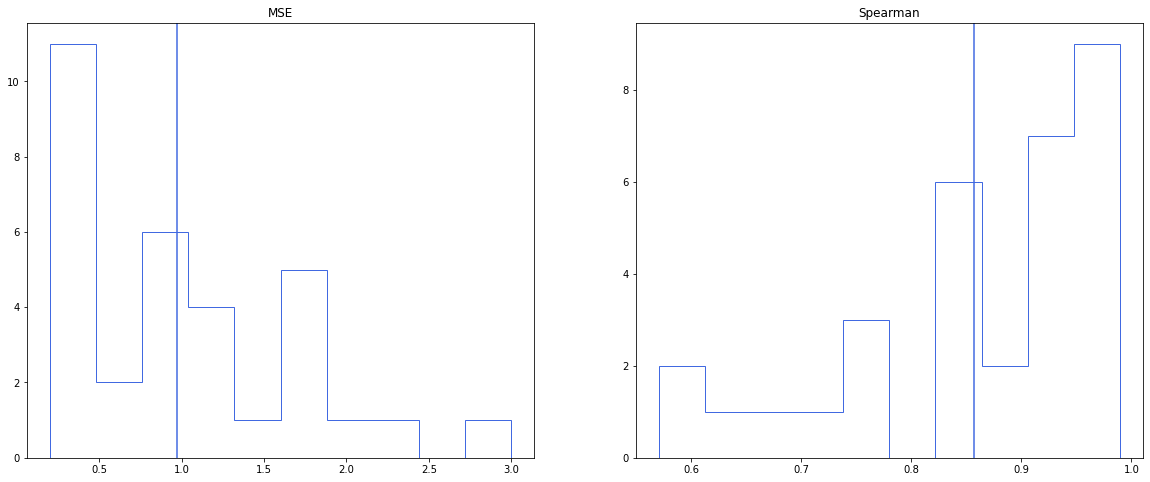

Average MSE: 0.97
Average Spearman: 0.857

Average MSE (prior): 53.71
Average MSE (empty): 4.21
Average MSE (complete): 53.71
Average Spearman (prior): nan


/local/56242785/ipykernel_4467/2549814663.py:46: RuntimeWarning: Mean of empty slice
  print("Average Spearman (prior): %.2f" % np.nanmean(prior_corrs))


In [11]:
# MSE and Spearman correlation of node features vs degree
mses, corrs = [], []
for g in graph_samples[-1]:
    degrees = dict(g.degree())
    node_degrees = np.array([degrees[n] for n in range(len(g))])
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    mses.append(np.mean(np.square(node_degrees - mean_feats)))
    corrs.append(scipy.stats.spearmanr(node_degrees, mean_feats)[0])
    
# Compute some baselines
prior_mses, prior_corrs = [], []
empty_mses = []
complete_mses = []
for g in graph_samples[0]:
    # Prior
    degrees = dict(g.degree())
    node_degrees = np.array([degrees[n] for n in range(len(g))])
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    prior_mses.append(np.mean(np.square(node_degrees - mean_feats)))
    prior_corrs.append(scipy.stats.spearmanr(node_degrees, mean_feats)[0])
    
    # Empty graph
    node_degrees = np.zeros_like(mean_feats)
    empty_mses.append(np.mean(np.square(node_degrees - mean_feats)))
    
    # Complete graph
    node_degrees = np.full_like(mean_feats, len(g) - 1)
    complete_mses.append(np.mean(np.square(node_degrees - mean_feats)))

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
ax[0].hist(mses, bins=10, histtype="step", color="royalblue")
ax[0].axvline(np.mean(mses), color="royalblue")
ax[0].set_title("MSE")
ax[1].hist(corrs, bins=10, histtype="step", color="royalblue")
ax[1].axvline(np.mean(corrs), color="royalblue")
ax[1].set_title("Spearman")
plt.show()

print("Average MSE: %.2f" % np.mean(mses))
print("Average Spearman: %.3f" % np.nanmean(corrs))

print()
print("Average MSE (prior): %.2f" % np.mean(prior_mses))
print("Average MSE (empty): %.2f" % np.mean(empty_mses))
print("Average MSE (complete): %.2f" % np.mean(complete_mses))
print("Average Spearman (prior): %.2f" % np.nanmean(prior_corrs))

0


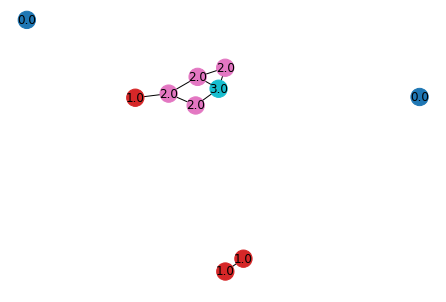

1


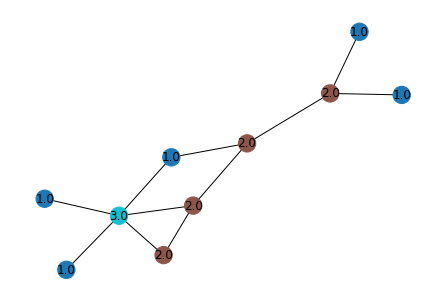

2


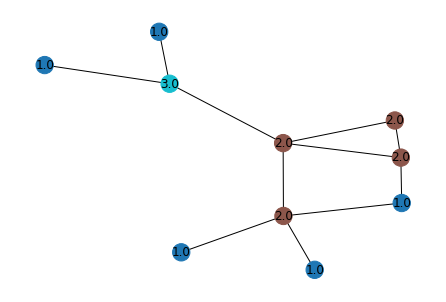

3


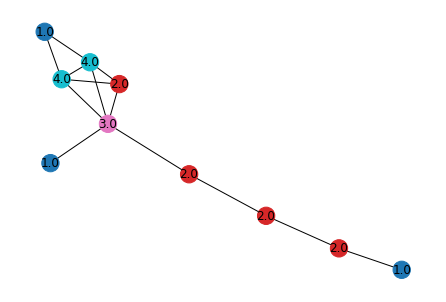

4


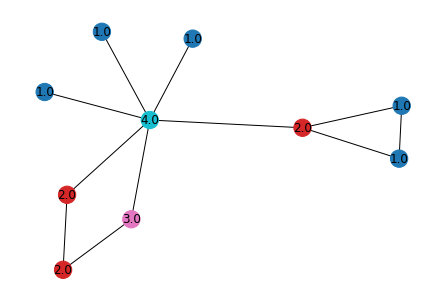

5


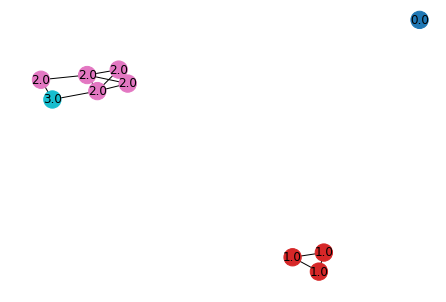

6


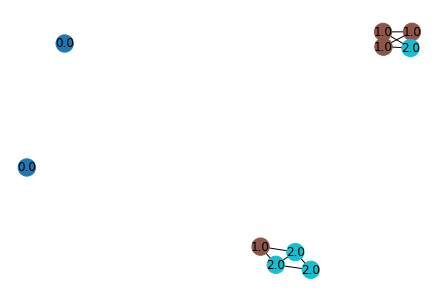

7


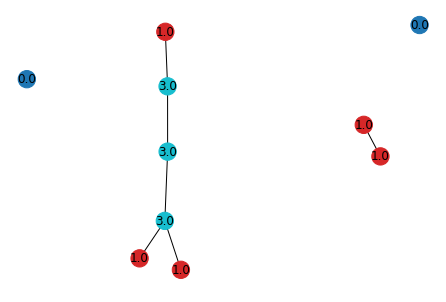

8


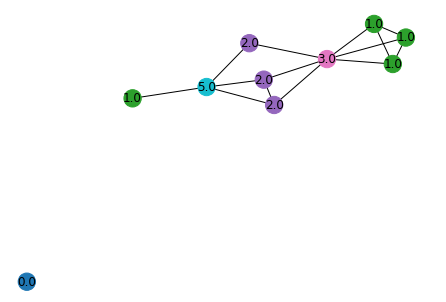

9


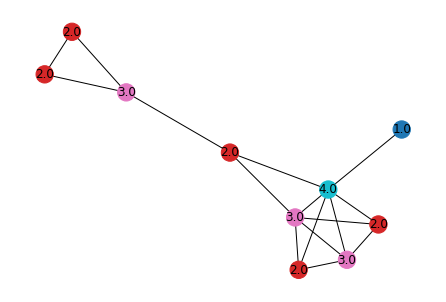

10


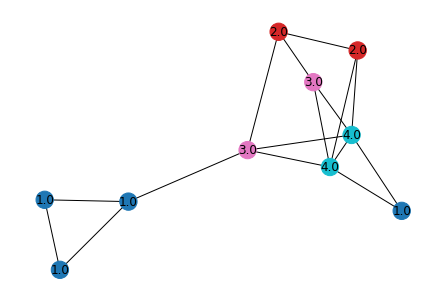

11


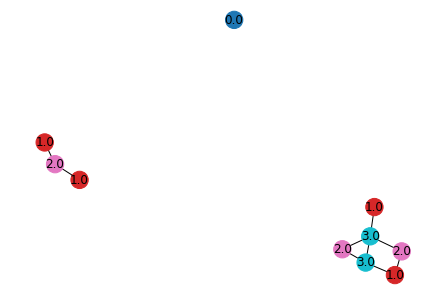

12


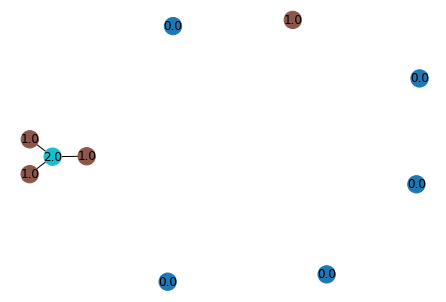

13


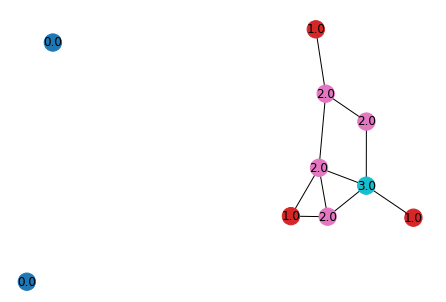

14


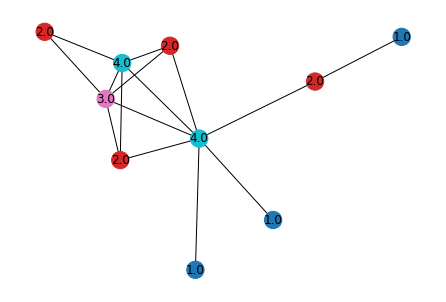

15


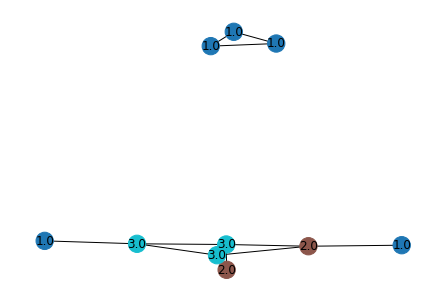

16


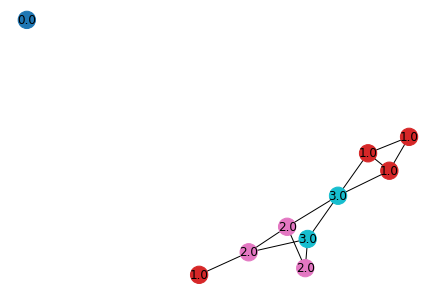

17


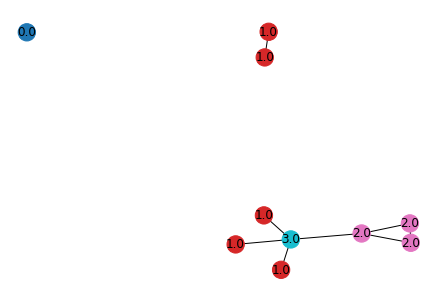

18


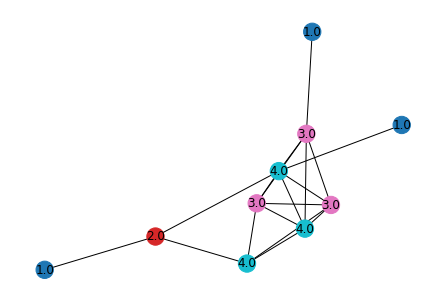

19


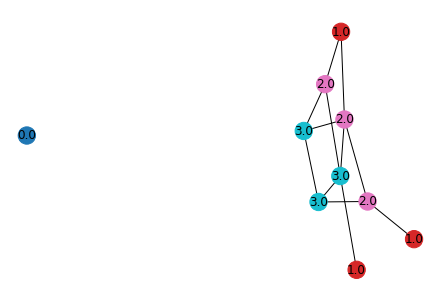

20


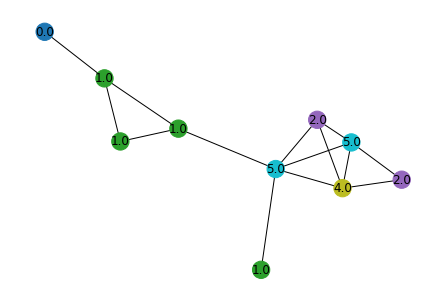

21


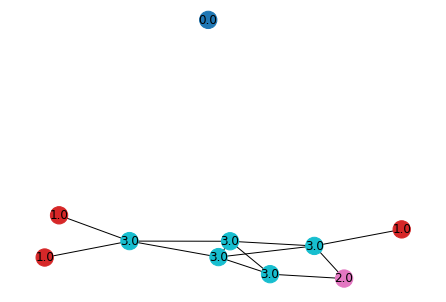

22


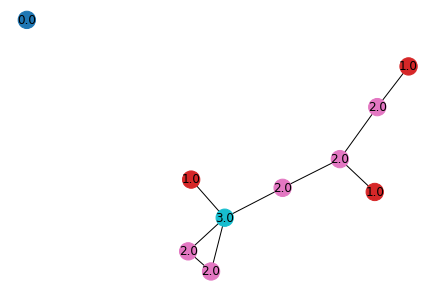

23


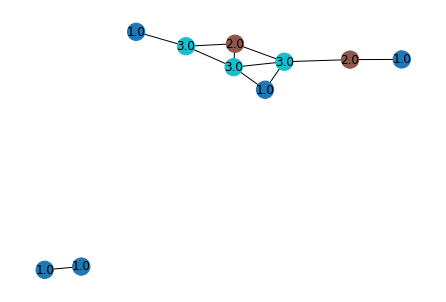

24


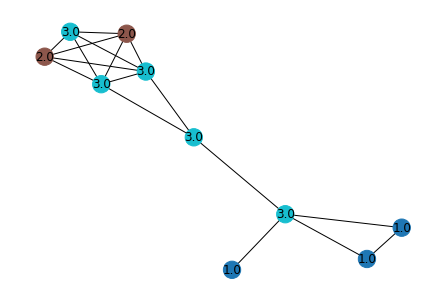

25


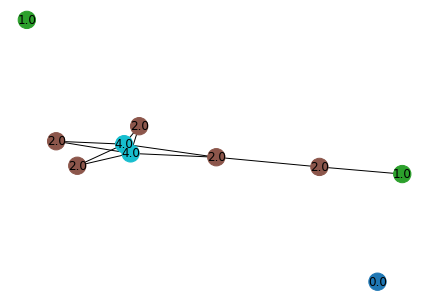

26


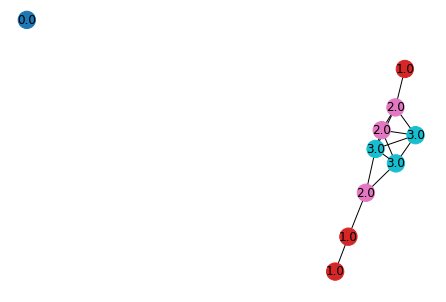

27


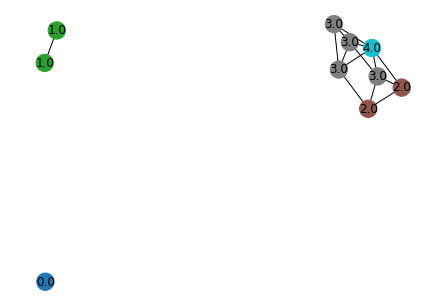

28


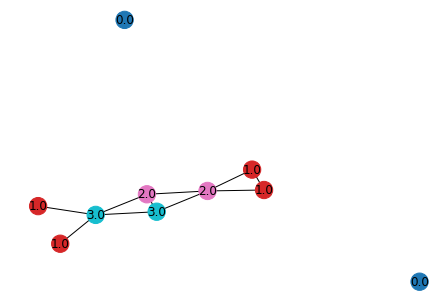

29


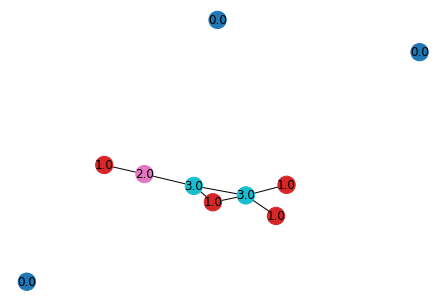

30


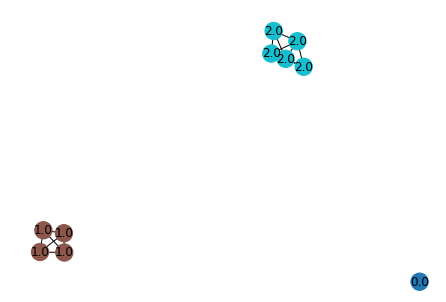

31


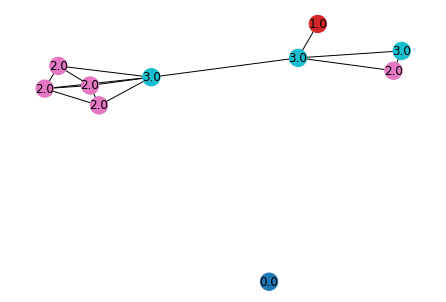

In [12]:
# Plot some randomly generated graphs
for i in range(len(graph_samples[-1])):
    print(i)
    g = graph_samples[-1][i]
    degrees = dict(g.degree())
    node_degrees = [degrees[n] for n in range(len(g))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(g, node_color=[round(labels[i]) for i in range(len(labels))], labels=labels, cmap="tab10")
    plt.show()